# Data Validation and some simple Statistics

In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import os
import json
import matplotlib.pyplot as plt
from glob import glob

First read in the table with the generally available metadata from the CODH.

In [3]:
overview = pd.read_csv("bukan-overview.csv")

Next, I drop all the lines where I manually decided to not consider the book. This is mostly because is was not a book to begin with or the scan was useless.

In [4]:
data = overview[overview["K?"] == "x"].drop("K?", 1)

Just checking if the `metadata.json` and the actual number of images is consistent. 

In [5]:
label_mapping = {}
for idx in data["国文研書誌ID"]:
    idx = int(idx)
    with open(f"data/{idx}/manifest.json", "r") as fd:
        manifest = json.load(fd)
        label = manifest["label"]
        alt_label = manifest["metadata"][3]["value"]
        if label in label_mapping and label_mapping[label] != alt_label:
            print(f"Inconsistent alternative label in {idx}: {label} <-> {alt_label}")
        label_mapping[label] = alt_label
        nr_pages = len(manifest["sequences"][0]["canvases"])
    images = glob(f"data/{idx}/image/*")
    if len(images) != nr_pages: print(f"WARNING book {idx}: {len(images)} images, {nr_pages} manifest pages")
    # print(f"book {idx}: {len(images)} images, {nr_pages} manifest pages")

WARNING book 200019503: 181 images, 180 manifest pages


In [6]:
hiragana_mapping = {
    'ほんちょうぶかん': "honchōbukan",
    'たいへいぶかん': "taihenbukan",
    'たいへいぶかんたいぜん': "taihenbukantaizen",
    'せいとうぶかん': "seitōbukan",
    'げんろくぶかんたいぜん': "genrokubukantaizen",
    'ほうえいぶかんたいせい': "hōeibukantaisen",
    'ごりんぶかん': "gorinbukan",
    'ほうえいぶかん': "hōeibukan",
    'しょうふうぶかん': "shōfūbukan",
    'しょうえんぶかん': "shōenbukan",
    'しょうとくぶかん': "shōtokubukan",
    'きょうほうぶかん': "kyōhōbukan",
    'えいせいぶかん': "eiseibukan", 
    'げんぶんぶかん': "genbunbukan",
    'かんぽうぶかん': "kanpōbukan",
    'えんきょうぶかん': "enkyōbukan",
    'かんえんぶかん': "kanenbukan",
    'ゆうしぶかん': "yūshibukan",
    'ほうりゃくぶかん': "hōryakubukan",
    'たいせいぶかん': "taiseibukan",
    'めいわぶかん': "meiwabukan",
    'たいへいりゃくぶかん': "taiheiryakubukan",
    'しゅうぎょくぶかん': "shūgyokubukan",
    'あんえいぶかん': "aneibukan",
    'しゅうちんぶかん': "shūchinbukan",
    'てんめいぶかん': "tenmeibukan",
    'まんじゅぶかん': "manjubukan",
    'かんせいぶかん': "kanseibukan",
    'きょうわぶかん': "kyōwabukan",
    'ぶんかぶかん': "bunkabukan",
    'ぶんせいぶかん': "bunseibukan",
    'かまくらぶかん': "kamakurabukan",
    'かいほうりゃくぶかん': "kaihōryakubukan", 
    'てんぽうぶかん': "tenpōbukan",
    'おうにんぶかん': "ōninbukan",
    'こうかぶかん': "kōkabukan",
    'ばんせいぶかん': "banseibukan",
    'かえいぶかん': "kaeibukan",
    'しょうえいぶかん': "shōeibukan",
    'あんせいぶかん': "anseibukan",
    'ぶんきゅうぶかん': "bunkyūbukan",
    'けいおうぶかん': "keiōbukan",
    'おくにわけぶかん': "okuniwakebukan",
    'かいほうおくにわけりゃくぶかん': "kaihō okuniwake ryakubukan"
}

## How many of the same Bukan do we have?
There are many editions of the same bukan. But how are these distributed exactly? Let's plot the book title and the number of books!

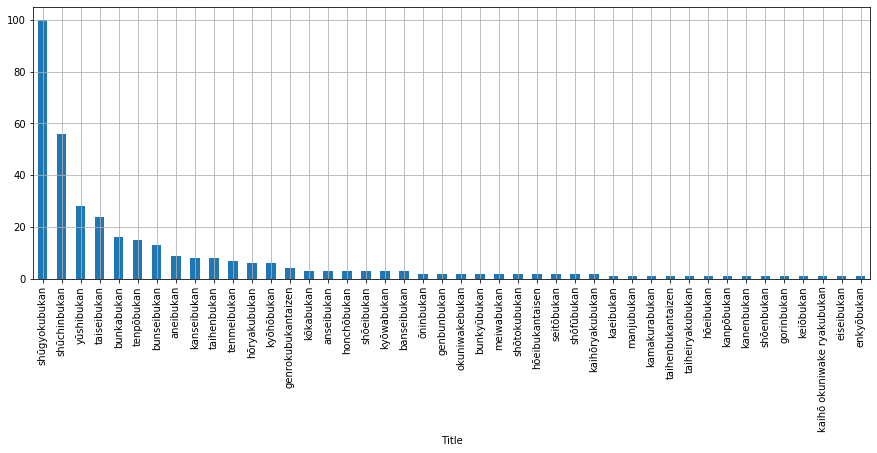

In [7]:
count_by_name = data.groupby("書名（統一書名）").count()["国文研書誌ID"]
count_by_name_index = count_by_name.index.map(label_mapping).map(hiragana_mapping)
count_by_name_index.name = "Title"
count_by_name.index = count_by_name_index
count_by_name_sorted = count_by_name.sort_values(ascending=False)
count_by_name_sorted.plot(kind="bar", figsize=(15,5), grid=True)

## Filtering out books

We can not compare books when there are not multiple editions available. Therefore I remove these lines from the overview table.

In [8]:
count_by_name_jap = data.groupby("書名（統一書名）").count()["国文研書誌ID"]
thresholded_larger_1 = data[data["書名（統一書名）"].map(lambda x: x in set(count_by_name_jap[count_by_name_jap > 1].index))]
thresholded_larger_1.shape

(338, 15)

And this is the Bukan with the most editions:

The **袖玉武鑑** (しゅうぎょくぶかん) (shūgyokubukan)

In [9]:
data[data["書名（統一書名）"] == "袖玉武鑑"]

,公開時期,国文研書誌ID,オープンデータ分類,書名（統一書名）,刊・写,原本請求記号,刊年・書写年,（西暦）,冊数等,(単位),X,Y,Width,Height,Comment
51,H29.12,200019397.0,政治・法制,袖玉武鑑,刊,ＭＹ－１２０１－２２５,宝暦１４,1764,1.0,冊,NaN,NaN,NaN,NaN,NaN
72,H29.12,200019400.0,政治・法制,袖玉武鑑,刊,ＭＹ－１２０１－２２７,天明８,1788,1.0,冊,NaN,NaN,NaN,NaN,NaN
73,H29.12,200019401.0,政治・法制,袖玉武鑑,刊,ＭＹ－１２０１－２２８,天明９,1789,1.0,冊,NaN,NaN,NaN,NaN,NaN
77,H29.12,200019406.0,政治・法制,袖玉武鑑,刊,ＭＹ－１２０１－２３０,寛政１０,1798,1.0,冊,NaN,NaN,NaN,NaN,NaN
82,H29.12,200019408.0,政治・法制,袖玉武鑑,刊,ＭＹ－１２０１－２３１,文化３,1806,1.0,冊,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
337,H29.12,200019639.0,政治・法制,袖玉武鑑,刊,ＭＹ－１２０１－３１２,慶応３,1867,1.0,冊,NaN,NaN,NaN,NaN,NaN
339,H29.12,200019641.0,政治・法制,袖玉武鑑,刊,ＭＹ－１２０１－３１２,慶応３,1867,1.0,冊,NaN,NaN,NaN,NaN,NaN
341,H29.12,200019643.0,政治・法制,袖玉武鑑,刊,ＭＹ－１２０１－３１２,慶応３,1867,1.0,冊,NaN,NaN,NaN,NaN,NaN
343,H29.12,200019646.0,政治・法制,袖玉武鑑,刊,ＭＹ－１２０１－３１３,慶応３,1867,1.0,冊,NaN,NaN,NaN,NaN,NaN
